In [1]:
from __future__ import unicode_literals, print_function, division
from vocab import vocab, END_TOKEN, START_TOKEN, PADDING_TOKEN, UNKNOWN_TOKEN
from helpers import readLines
from load_data import load_data_evaluate, load_data_training
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import json

PHRASE_SIZE = 50
BATCH_SIZE = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# ENCODER

In [2]:
class EncoderRNN(nn.Module):
  def __init__(self, type_vocab, value_vocab, hidden_size, embedding_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.typeEmbedding = nn.Embedding(len(type_vocab), embedding_size, device=device)
    self.valueEmbedding = nn.Embedding(len(value_vocab), embedding_size, device=device)
    self.positionEmbedding = nn.Embedding(PHRASE_SIZE, 10, device=device)
    
    self.gru = nn.GRU(embedding_size * 2 + 10, self.hidden_size)

  def forward(self, inputs, hidden):
    E_type_out = self.typeEmbedding(inputs[0])
    E_value_out = self.valueEmbedding(inputs[1])
    E_pos_out = self.positionEmbedding(inputs[2])

    output = torch.cat((E_type_out, E_pos_out, E_value_out), dim=1).view(1, BATCH_SIZE, -1)

    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

# DECODER

In [3]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size, device=device)
    
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    output = self.embedding(input)

    output = F.relu(output)
    
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

# ATTENTION DECODER

In [4]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=PHRASE_SIZE):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, BATCH_SIZE, -1)
    embedded = self.dropout(embedded)

    # print(embedded.shape, hidden.shape)
    # print(embedded[0].shape, hidden[0].shape)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

# TIMING & PLOT

In [5]:
import time
import math

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)


def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.05)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)
  plt.show()

# INPUT

In [6]:
type_vocab, value_vocab, token_vocab, pairs = load_data_training(torch, device, 50000, BATCH_SIZE, PHRASE_SIZE, 100)

selected 100 pairs out of 78523 available
------------------------
loading data: 10/100 (10%)
loading data: 20/100 (20%)
loading data: 30/100 (30%)
loading data: 40/100 (40%)
loading data: 50/100 (50%)
loading data: 60/100 (60%)
loading data: 70/100 (70%)
loading data: 80/100 (80%)
loading data: 90/100 (90%)
loading data: 100/100 (100%)
------------------------
pairs:  100
batch size: 5, phrase size: 50
input shape:  torch.Size([3, 5, 50])
output shape:  torch.Size([5, 50])


In [7]:
test = pairs[0]
target = test[1]

for sentence in target:
  s = ""
  for word in sentence:
    s += token_vocab.getWord(word.item()) + " "
  print(s)
  

a very tall man <UNK> / 6' <UNK> nicholas, named after his paternal grandfather, the emperor, was born as the eldest son to grand duke nicholas <UNK> of russia <UNK> and alexandra <UNK> of oldenburg <UNK> on 18 november 1856. his father was the sixth child and third son <EOS> 
<UNK> scored two goals in the final of the 2013 coupe de france to help bordeaux defeat evian <UNK> 3-2. <UNK> had an excellent 2013-14 ligue 1 season with bordeaux, registering 12 goals in 25 ligue 1 matches and scoring in a 1-1 away draw against toulouse fc, one <EOS> 
this large <UNK> earns its common name from its dark <UNK> <UNK> <UNK> which perfectly <UNK> it against the <UNK> <UNK> <UNK> upon which it <UNK> <UNK> its body is primarily black, but features brown markings along its long, slender <UNK> it is particularly at the <UNK> between segments, <EOS> 
the varied habitats support a wide variety of bird species, 34 of which occur in the <UNK> areas alone. species of note include the <UNK> <UNK> eastern gr

# TRAINING

In [8]:
teacher_forcing_ratio = 0.5

# NOTE: inputs are (1, BATCH_SIZE)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(2) # == PHRASE_SIZE
  target_length = target_tensor.size(1)

  # NOTE: attention
  encoder_outputs = torch.zeros(PHRASE_SIZE, encoder.hidden_size, device=device)

  loss = 0

  for i in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[:,:,i], encoder_hidden)
    # NOTE: attention
    encoder_outputs[i] = encoder_output[0, 0]

  decoder_input = torch.tensor([[type_vocab.getID(START_TOKEN)] for _ in range(BATCH_SIZE)], device=device)
  decoder_input = decoder_input.view(1, BATCH_SIZE)

  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  # use_teacher_forcing = False

  if use_teacher_forcing:
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      loss += criterion(decoder_output, target_tensor[:,di])
      decoder_input = target_tensor[:, di].view(1, BATCH_SIZE)  # Teacher forcing
      
  else:
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
      # NOTE: attention
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      # decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.topk(1)
      # decoder_input = topi.squeeze().detach().view(1, BATCH_SIZE)  # detach from history as input
      decoder_input = topi

      loss += criterion(decoder_output, target_tensor[:,di])

  # loss.backward()
  loss = loss / target_length
  # loss = loss / BATCH_SIZE
  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [9]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=5e-5):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  training_pairs = [random.choice(pairs) for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                      iter, iter / n_iters * 100, print_loss_avg))

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  
  showPlot(plot_losses)


In [10]:

encoder = EncoderRNN(type_vocab, value_vocab, 256, 128).to(device)
# decoder = DecoderRNN(256, len(token_vocab)).to(device)
decoder = AttnDecoderRNN(256, len(token_vocab)).to(device)

# ITERS = 200000
# trainIters(encoder, decoder, ITERS, print_every=ITERS/10, plot_every=ITERS/100)

# EVALUATION

In [11]:
def evaluate(encoder, decoder, input_tensor, max_length=PHRASE_SIZE):
  with torch.no_grad():
    input_length = input_tensor.size(2) # == max_length
    encoder_hidden = encoder.initHidden()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[:,:,ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[type_vocab.getID(START_TOKEN)] for _ in range(BATCH_SIZE)], device=device)
    decoder_input = decoder_input.view(1, BATCH_SIZE)

    decoder_hidden = encoder_hidden

    decoded_words = [[] for _ in range(BATCH_SIZE)]
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      
      # TODO: decoder attention
      # decoder_attentions[di] = decoder_attention.data
      # print("out" + str(decoder_output[0:10]))
      topv, topi = decoder_output.data.topk(1)
      # print(topv)
      # print(topi)

      # TODO: end tokens dopo fine della frase
      for i in range(BATCH_SIZE):
        decoded_words[i].append(token_vocab.getWord(topi[i].item()))

      decoder_input = topi.squeeze().detach().view(1, BATCH_SIZE)  # detach from history as input

    return decoded_words, decoder_attentions[:di + 1]

In [12]:
inputs = load_data_evaluate(torch, device, type_vocab, value_vocab, BATCH_SIZE, PHRASE_SIZE, 10)

selected 10 pairs out of 10 available
------------------------
loading data: 1/10 (10%)
loading data: 2/10 (20%)
loading data: 3/10 (30%)
loading data: 4/10 (40%)
loading data: 5/10 (50%)
loading data: 6/10 (60%)
loading data: 7/10 (70%)
loading data: 8/10 (80%)
loading data: 9/10 (90%)
loading data: 10/10 (100%)
------------------------
pairs:  10
batch size: 5, phrase size: 50
input shape:  torch.Size([3, 5, 50])


In [13]:
# print(len(inputs))

# print(inputs[0].shape)

# outputs, attn = evaluate(encoder, decoder, inputs[0])

# for phrase in outputs:
#   print("----------------------")
#   s = ""
#   for word in phrase:
#     s += " " + str(word)
#   print(s)

# PAIRS TEST
# test = pairs[0][1]
# print(test[0])

# for phrase in test:
#   s = ""
#   for word in phrase:
#     s += " " + token_vocab.getWord(word.item())

#   print(s)

# EVAL INPUT TEST
# test = inputs[0]
# print(test.shape)
# print("----------------------")

# for phrase in test[0]:
#   s = ""
#   for word in phrase:
#     s += " | " + type_vocab.getWord(word.item()) + " [" + str(word.item()) + "]"
#   print(s)

# print("----------------------")

# for phrase in test[1]:
#   s = ""
#   for word in phrase:
#     s += " | " + value_vocab.getWord(word.item()) + " [" + str(word.item()) + "]"
#   print(s)

----========= CYCLE 1/10 - 1 iterations =========----


<Figure size 432x288 with 0 Axes>

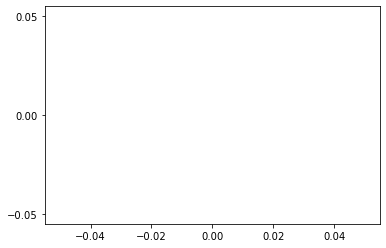

----========= CYCLE 2/10 - 2 iterations =========----


<Figure size 432x288 with 0 Axes>

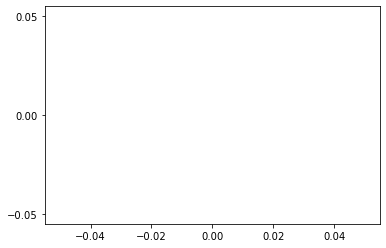

----========= CYCLE 3/10 - 3 iterations =========----


<Figure size 432x288 with 0 Axes>

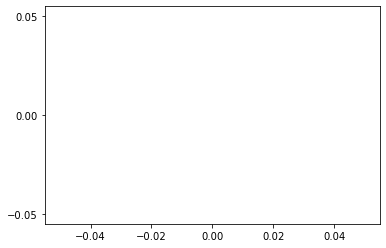

----========= CYCLE 4/10 - 4 iterations =========----


<Figure size 432x288 with 0 Axes>

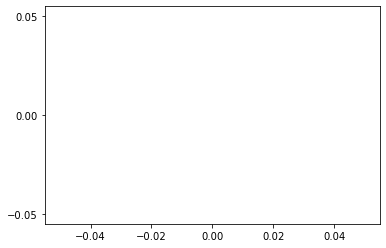

----========= CYCLE 5/10 - 5 iterations =========----


<Figure size 432x288 with 0 Axes>

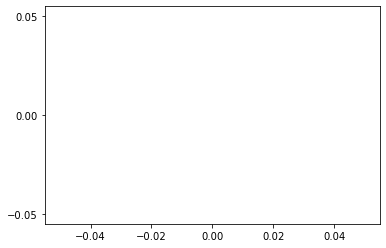

----========= CYCLE 6/10 - 6 iterations =========----


<Figure size 432x288 with 0 Axes>

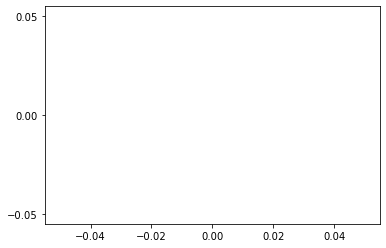

----========= CYCLE 7/10 - 7 iterations =========----


<Figure size 432x288 with 0 Axes>

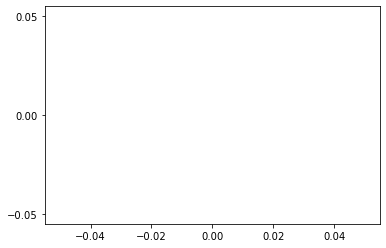

----========= CYCLE 8/10 - 8 iterations =========----


<Figure size 432x288 with 0 Axes>

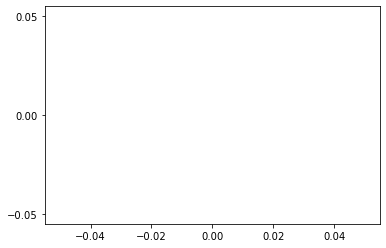

----========= CYCLE 9/10 - 9 iterations =========----


<Figure size 432x288 with 0 Axes>

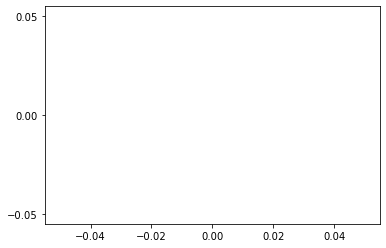

----========= CYCLE 10/10 - 10 iterations =========----


<Figure size 432x288 with 0 Axes>

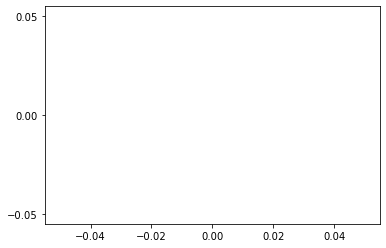

In [47]:
from datetime import datetime

ITERS = 1

test_input = pairs[0][0]

now = str(datetime.now().strftime("%d.%m-%H.%M"))

with open(f"output/out-{now}.txt", 'w', encoding='utf-8') as outfile:
  pass

with open(f"output/out-{now}.txt", 'a', encoding='utf-8') as outfile:
  for i in range(10):
    print(f"----========= CYCLE {i+1}/10 - {ITERS*(i+1)} iterations =========----")
    outfile.write(f"\n----========= CYCLE {i+1}/10 - {ITERS*(i+1)} iterations =========----\n\n")

    trainIters(encoder, decoder, ITERS, print_every=ITERS/5, plot_every=ITERS/1000)
    outputs, _ = evaluate(encoder, decoder, test_input)
    
    for i in range(len(outputs)):
      outfile.write("----------------------\n")
      predict = ""
      target = ""
      for word in outputs[i]:
        predict += str(word) + " "
      outfile.write(predict + "\n")
      outfile.write("-.... ↑|predict|↑ ....... ↓|target|↓ ....-\n")
      for word in pairs[0][1][i]:
        target += token_vocab.getWord(word.item()) + " "
      outfile.write(target + "\n")
      